![](https://f-origin.hypotheses.org/wp-content/blogs.dir/253/files/2020/12/AICROWD.png)

This notebook will examine the competition data in more detail! Ideal for new members.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
df = pd.read_csv('/kaggle/input/motor-insurance-market/training (1).csv')

In [3]:
df.head()

id_policy  year  pol_no_claims_discount pol_coverage  pol_duration  \
0  PL000000   1.0                   0.332         Med2             5   
1  PL042495   1.0                   0.000         Med2             6   
2  PL042496   1.0                   0.196         Med1             2   
3  PL042497   1.0                   0.000         Med2             8   
4  PL042498   1.0                   0.000         Med1             2   

   pol_sit_duration pol_pay_freq pol_payd    pol_usage drv_sex1  ...  \
0                 1      Monthly       No  WorkPrivate        M  ...   
1                 1      Monthly       No  WorkPrivate        M  ...   
2                 1       Yearly      Yes      Retired        M  ...   
3                 5       Yearly       No  WorkPrivate        F  ...   
4                 2       Yearly       No      Retired        F  ...   

      vh_make_model  vh_age   vh_fuel     vh_type  vh_speed  vh_value  \
0  aparvvfowrjncdhp     8.0  Gasoline     Tourism     174.0   11040.0   
1  aparvvfowrjncdhp    10.0    Diesel     Tourism     174.0   11040.0   
2  iwhqpdfuhrsxyqxe     8.0    Diesel  Commercial     150.0   14159.0   
3  kvcddisqpkysmvvo     4.0  Gasoline     Tourism     149.0   17233.0   
4  tdgkjlphosocwbgu    13.0  Gasoline     Tourism     200.0   19422.0   

  vh_weight  population town_surface_area claim_amount  
0    1143.0      1270.0              33.1          0.0  
1    1143.0      1290.0              51.3          0.0  
2    1193.0      1020.0             262.8          0.0  
3    1012.0       180.0             219.7          0.0  
4    1315.0        30.0              70.3          0.0  

[5 rows x 26 columns]

# Understanding data

The training set presents policy data for the last 4 years for each user. Let's check it out.

In [4]:
df.id_policy.value_counts()

PL008115    4
PL011513    4
PL057669    4
PL033195    4
PL043079    4
           ..
PL088572    4
PL052667    4
PL036222    4
PL028661    4
PL006028    4
Name: id_policy, Length: 57054, dtype: int64

## Let's get acquainted with ordinal, categorical and binary features:

**Ordinal:**

* pol_coverage: *Min, Med1, Med2, Max, in this order.*

**Categorical:**

* pol_pay_freq: *the price of the insurance coverage can be paid anually, bi-anually, quarterly or monthly.*
* pol_usage: *WorkPrivate, Retired, Professional, AllTrips.*
* drv_sex1: *H or F.*
* drv_sex2: *H or F*.
* vh_make_model: *hashes representing car models, such as Honda Civic or Fiat Uno.*
* vh_fuel: *Diesel, Gasoline or Hybrid.*
* vh_type: *Tourism or Commercial.*

**Boolean:**

* pol_payd: *Pay As You Drive. Indicates whether a client subscribed a mileaged-base policy or not.*
* drv_drv2: *Indicates the presence of a secondary driver in the contract.*

## Missing data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  object 
 1   year                    228216 non-null  float64
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  object 
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  object 
 7   pol_payd                228216 non-null  object 
 8   pol_usage               228216 non-null  object 
 9   drv_sex1                228216 non-null  object 
 10  drv_age1                228216 non-null  float64
 11  drv_age_lic1            228216 non-null  float64
 12  drv_drv2                228216 non-null  object 
 13  drv_sex2                228216 non-null  object 
 14  drv_age2            

Note that there is a lot of missing data associated with the second driver. This is most likely due to the fact that there is no second driver. These missing values may need to be categorized into new categories.

# Data analysis

## Correlations

Unfortunately, there are very few dependencies on the target variable. Getting good predictions won't be easy.)

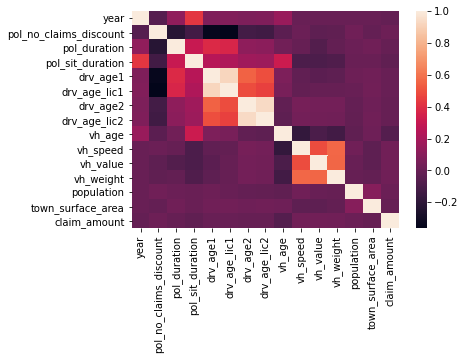

In [6]:
sns.heatmap(df.corr())

## Target

Let's see what the distribution of the target variable looks like. Expectedly, there are many zeros, which means that the person was not hurt. There is also a long right tail.

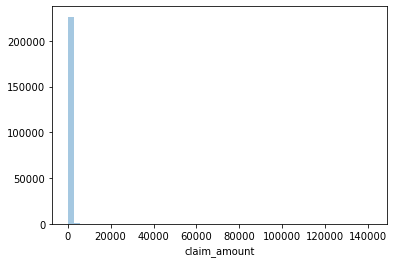

In [7]:
sns.distplot(df['claim_amount'], kde=False)

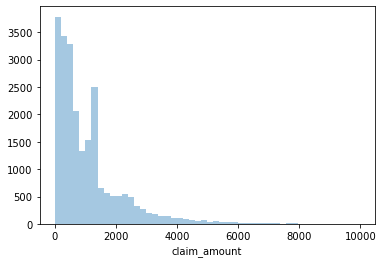

In [8]:
sns.distplot(df[(df['claim_amount'] > 0) & (df['claim_amount'] < 10000)]['claim_amount'], kde=False)

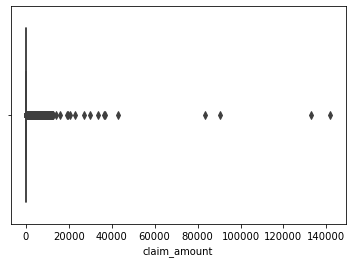

In [9]:
sns.boxplot(df['claim_amount'])

Now let's look at the ratio of those who have suffered and not.

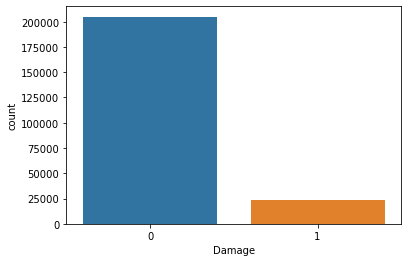

In [10]:
df['Damage'] = np.where(df['claim_amount'], 1, 0)
sns.countplot(df['Damage'])

## Categorical features

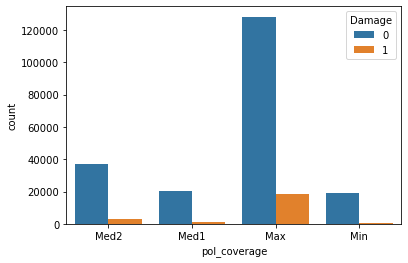

In [11]:
sns.countplot('pol_coverage', data=df, hue = 'Damage')

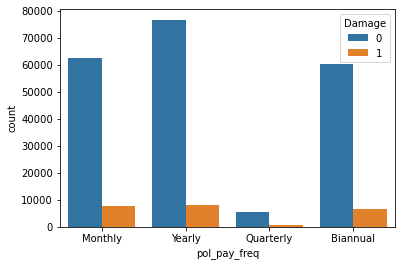

In [12]:
sns.countplot('pol_pay_freq', data=df, hue ='Damage')

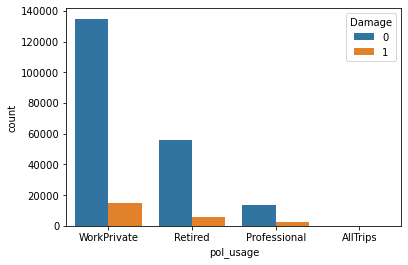

In [13]:
sns.countplot('pol_usage', data=df, hue='Damage')

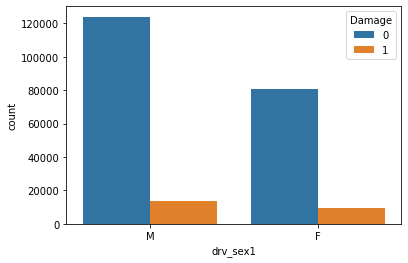

In [14]:
sns.countplot('drv_sex1', data=df, hue='Damage')

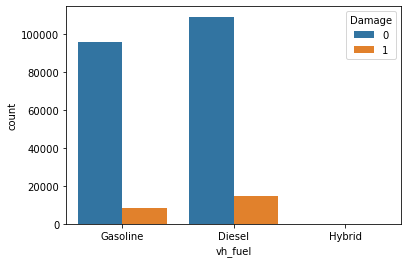

In [15]:
sns.countplot('vh_fuel',data=df, hue='Damage')

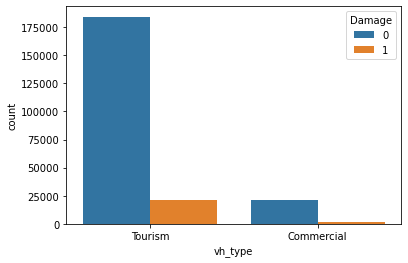

In [16]:
sns.countplot('vh_type',data=df, hue='Damage')

## Crashes

Find out how many users have not received damage for 4 years, as well as the rest who have received damage.

In [17]:
count_damage_per_user = df.groupby('id_policy')['Damage'].sum()
count_damage_per_user.value_counts()

0    38518
1    14440
2     3495
3      542
4       59
Name: Damage, dtype: int64

Let's explore which data depends and changes over time. For some users, they received that their gender was changed. I think we need to investigate this in more detail.

In [18]:
no_change, change = [], []
for column in df.columns:
    constant_cells = (df.groupby(['id_policy'])[column].value_counts() == 4).all()
    if constant_cells:
        no_change.append(column)
    else:
        change.append(column)

In [19]:
change

['year',
 'pol_no_claims_discount',
 'pol_duration',
 'pol_sit_duration',
 'pol_pay_freq',
 'drv_sex1',
 'drv_age1',
 'drv_age_lic1',
 'drv_age2',
 'drv_age_lic2',
 'vh_age',
 'population',
 'town_surface_area',
 'claim_amount',
 'Damage']